In [1]:
def plotcolors_tefflogg(xmin,xmax,ymin,ymax,alpha=0.15,yval=1.2,fontsize=16):
    colors = [
        #{"min": 6000, "max": 74900, "alpha": alpha, "color": '#5b7cff', "label": 'O'},
        #{"min": -0.25, "max": 6000, "alpha": alpha, "color": '#6988ff', "label": 'B'},
        {"min": np.log10(7400), "max": np.log10(9700), "alpha": alpha, "color": '#93aaff', "label": 'A'},
        {"min": np.log10(6000), "max": np.log10(7399), "alpha": alpha, "color": '#dddeff', "label": 'F'},
        {"min": np.log10(5200), "max": np.log10(6000), "alpha": alpha, "color": '#ffebdf', "label": 'G'},
        {"min": np.log10(3700), "max": np.log10(5199), "alpha": alpha, "color": '#ffb177', "label": 'K'},
        {"min": np.log10(3000), "max": np.log10(3700), "alpha": alpha, "color": '#ffa448', "label": 'M'}]
    for c in colors:
        if c["min"] < xmax and c["max"] > xmin: # Check if the color is within xmin and xmax
            teff1 = max(c["min"], xmin)
            teff2 = min(c["max"], xmax)

            plt.axvspan(teff1, teff2, alpha=c["alpha"], color=c["color"], zorder=1)
            val = teff1 + (teff2 - teff1) / 2
            plt.annotate(c["label"], xy=(val, yval), xytext=(val, yval), fontsize=fontsize,zorder=8)
    return

#import smplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import numpy as np
import mesa_reader as mr

- (1) [small scatter] run a scatter job to create zero-age main sequence (ZAMS) stars (shown in the upper left hand corner). Each star has a unique set of parameters (mass, y abundance, z abundance).
- (2) [small scatter extended] run a second scatter job to evolve all those ZAMS stars all the way to the tip of the red giant branch (top right "control sample" output).  the number of jobs in (1) = the number of jobs in (2)
- (3) [big scatter] run a scatter job on the ZAMS stars again, but this time let accretion happen. Vary the accretion parameters (total mass of the accretion disk, the accretion rate, the helium fraction of that disk, the metal fraction of that disk). This is where we go from a small group of files to a much larger number, depending on the parameter sweep bins.
- (4) [big scatter extended] run another scatter job, now just letting all the files produced in step (3) evolve to the red giant tip. now we can watch them thermally relax onto an M+delta(M) stellar track. the number of jobs in (3) = the number of jobs in (4) 

---

Let's start with a small scatter to generate our ZAMS stars. We will start with just two stellar masses and a single X,Y,Z chemistry combination. 

- Masses =[1.0 $M_{\odot}$, 1.075 $M_{\odot}$]
- Initial H Mass Fraction X=0.7157 
- Initial He Mass Fraction, Y=0.2703 
- Initial Metallicity, Z=0.014

---

Let's call this ZAMS star `ZAMS_1Msun_Y0p2703_Z0p14.mod`. We don't need to specify X, as it is implied from the relation $X+Y+Z=1$.

I'll need to generate another ZAMS star, which has the $M+\Delta M$ mass of our accretor star. This is an important control stellar track for our accretion test case. It'll show when our accretor has effecitvely thermally relaxed. 

We will call this second star `ZAMS_1p075Msun_Y0p2703_Z0p14.mod` because our $1 M_{\odot}$ star will accrete $\Delta M$=0.075 Msun in this case. 

In [14]:
import camber

In [5]:
import time
ts = time.time()

jobs=camber.mesa.create_scatter_job(
    param_sets=[
        {"INLIST":"'inlist_create_zams'", "INIT_MASS":"1.0","OUTPUT_MOD":"'ZAMS_1Msun_Y0p2703_Z0p14.mod'"}, #0001
        {"INLIST":"'inlist_create_zams'", "INIT_MASS":"1.075","OUTPUT_MOD":"'ZAMS_1p075Msun_Y0p2703_Z0p14.mod'"}, #0002
    ],
    inlist_files=['inlist','inlist_pgstar','inlist_create_zams'],
    worker_size='SMALL',)

In [6]:
jobs

[MesaJob({"job_id": 623, "status": "PENDING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0002", "tags": null}),
 MesaJob({"job_id": 624, "status": "PENDING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0001", "tags": null})]

---

**"SMALL" worker size:**

To get a single job *started* using a "SMALL" worker size, took **3 minutes**. By "started" I am referring to the generation of output files in the LOGS directory. I'll call this the *"start time."*

It takes about **5 minutes** to run two "scatter" jobs from molecular cloud collapse to the onset of ZAMS. I'll call this the *"run time."*  

Mind you, we are using default time step sizes. Run time will increase when one sets a maximum time step constraint. Such constraints are critical when modeling the accretion process (3). 

----

**"MEDIUM" worker size:**

To get a single job *started* using a "MEDIUM" worker size, it takes **less than one minute.** By "started" I am referring to the generation of output files in the LOGS directory. I'll call this the *"start time."*

It takes about **6 minutes** to run two "scatter" jobs from molecular cloud collapse to the onset of ZAMS. I'll call this the *"run time."*  

Mind you, we are using default time step sizes. Run time will increase when one sets a maximum time step constraint. Such constraints are critical when modeling the accretion process (3). 


---

**"LARGE" worker size:**

The start time for the LARGE worker size is much greater. It took more than **5 minutes** both jobs started. The first job finished before the second started. Total run time for two jobs was **7 minutes.** Thus, it's more efficient to go with a MEDIUM worker size.

---

It would be great if the `ZAMS_1Msun_Y0p2703_Z0p14.mod` and `ZAMS_1p075Msun_Y0p2703_Z0p14.mod` files in the `0001` and `0002` direcotries could be ported to a directory called `ZAMS`. Instead, I'll move them manually in this next step.

In [111]:
!mv 0001/*.mod .
!mv 0002/*.mod .
!rm -r 000*

mv: cannot stat '0001/*.mod': No such file or directory
mv: cannot stat '0002/*.mod': No such file or directory
rm: cannot remove '000*': No such file or directory


Now we start a large scatter job, drawing from the ZAMS .mod file made in the prior step. We will alternate the Mdot value. 

In [891]:
# Generate 32 evenly spaced values
no_jobs=8 #32

# Define min and max accretion values to override the following command
#mass_change = 0d0
min_value = 1.0e-11 #1.0e-11
max_value = 1.0e-4 #-4
accrate = np.logspace(np.log10(min_value), np.log10(max_value), num=no_jobs)

#MESA has two kinds of limiting timestep controls: hard and soft. 
#If a step violates a hard limit, MESA will do a retry (with a smaller timestep). 
#If a step violates a soft limit, then MESA will decrease the timestep for the next step.
# Define min and max timestep limit values to override the following commands
#delta_lg_star_mass_limit = 5d-3
#delta_lg_star_mass_hard_limit = -1
#mass_val = 1.0e-11
#dm = [mass_val]*(no_jobs)

#Define History Interval
histval=100
histval=[histval]*(no_jobs)

# Define min and max timestep limit values to override the following commands
#max_years_for_timestep
min_value = 1e-3 #dynamical timescale of the sun is 1000 seconds or 1e-5 yr
max_value = 1e4
dt = np.logspace(np.log10(min_value), np.log10(max_value), num=no_jobs)
dt = dt[::-1]

print(accrate)
print(histval)
print(dt)

[1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04]
[100, 100, 100, 100, 100, 100, 100, 100]
[1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03]


In [895]:
jobs.clear()
!rm -r 00*

In [896]:
param_sets=[
    {
        "MODEL_NAME": "'inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod'",
        "INLIST": "'inlist_project_accrete'",
        "INIT_MASS": "1.0",
        "ACCRETE": f"{accrate[i]}",
        "HISTVAL": f"{histval[i]}",
        "MAXTIME": f"{dt[i]}"} for i in range(no_jobs)
]
param_sets

[{'MODEL_NAME': "'inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod'",
  'INLIST': "'inlist_project_accrete'",
  'INIT_MASS': '1.0',
  'ACCRETE': '1e-11',
  'HISTVAL': '100',
  'MAXTIME': '10000.0'},
 {'MODEL_NAME': "'inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod'",
  'INLIST': "'inlist_project_accrete'",
  'INIT_MASS': '1.0',
  'ACCRETE': '1e-10',
  'HISTVAL': '100',
  'MAXTIME': '1000.0'},
 {'MODEL_NAME': "'inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod'",
  'INLIST': "'inlist_project_accrete'",
  'INIT_MASS': '1.0',
  'ACCRETE': '1e-09',
  'HISTVAL': '100',
  'MAXTIME': '100.0'},
 {'MODEL_NAME': "'inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod'",
  'INLIST': "'inlist_project_accrete'",
  'INIT_MASS': '1.0',
  'ACCRETE': '1e-08',
  'HISTVAL': '100',
  'MAXTIME': '10.0'},
 {'MODEL_NAME': "'inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod'",
  'INLIST': "'inlist_project_accrete'",
  'INIT_MASS': '1.0',
  'ACCRETE': '1e-07',
  'HISTVAL': '100',
  'MAXTIME': '1.0'},
 {'MODEL_NAME': "'inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod'",
  'INLIST': "'inlist_pr

In [897]:
jobs = camber.mesa.create_scatter_job(
    param_sets=param_sets,
    inlist_files=['inlist_ZAMS_1Msun_Y0p2703_Z0p14.mod', 'inlist', 'inlist_pgstar', 'inlist_project_accrete'],
    worker_size='SMALL',) 
#SMALL: OMP_NUM_THREADS=16
#SMALL is optimal for this task, XSMALL is 2x slower and MEDIUM is 10x slower

In [898]:
jobs

[MesaJob({"job_id": 1098, "status": "RUNNING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0003", "tags": null}),
 MesaJob({"job_id": 1096, "status": "RUNNING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0002", "tags": null}),
 MesaJob({"job_id": 1097, "status": "RUNNING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0001", "tags": null}),
 MesaJob({"job_id": 1102, "status": "PENDING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0007", "tags": null}),
 MesaJob({"job_id": 1101, "status": "PENDING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0006", "tags": null}),
 MesaJob({"job_id": 1100, "status": "RUNNING", "worker_size": "SMALL", "job_type": "MESA", "command": "./mk && ./rn", "file_dir": "0005", "tags": null}),
 MesaJob({"job_id": 1099, "status": "RUNNING", "worker_size": "SMALL", "job_

7502
7502
7502
7502
7502
7502
7503
7505


Text(0.5, 1.0, '$1\\,M_{\\odot}, \\mathrm{Z} = 0.014, \\mathrm{Y} = 0.2703$')

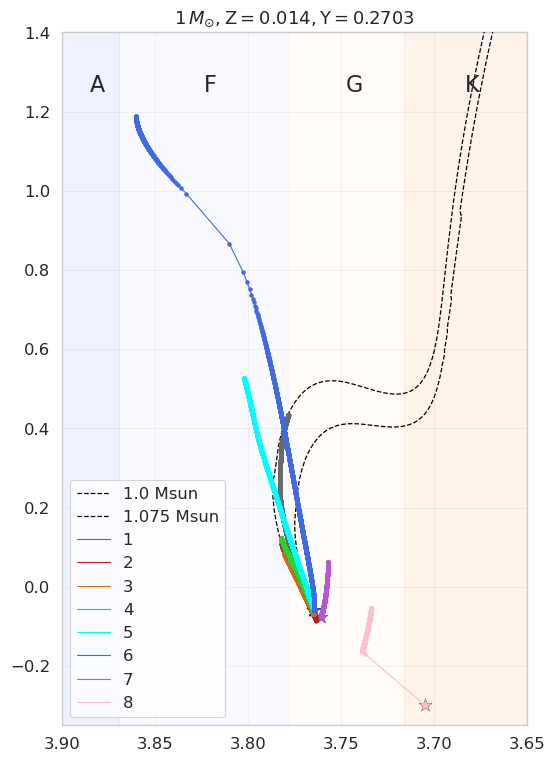

In [1019]:
fig = plt.figure(figsize=(6,9))
sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.35)
maxx=3.9
minx=3.65
maxy=1.4
miny=-0.35
plotcolors_tefflogg(yval=1.25,xmin=minx,xmax=maxx,ymin=miny,ymax=maxy)

#controls 
strin='Control_MS_to_WD/1Msun_Y0p2703_Z0p14/LOGS/history.data'
h=mr.MesaData(strin)
plt.plot(h.log_Teff,h.log_L,linestyle='dashed',color='black',linewidth=0.9,zorder=7,rasterized=True,label='1.0 Msun')
strin='Control_MS_to_WD/1p075Msun_Y0p2703_Z0p14/LOGS/history.data'
h=mr.MesaData(strin)
plt.plot(h.log_Teff,h.log_L,linestyle='dashed',color='black',linewidth=0.9,zorder=7,rasterized=True,label='1.075 Msun')

values_list = [f"{i:04d}" for i in range(1, no_jobs+1)]

# Create variables dynamically
for idx, v in enumerate(values_list, start=1):
    strin = v + '/LOGS/history.data'
    variable_name = f"h{idx}"
    globals()[variable_name] = mr.MesaData(strin)
    print(len(globals()[variable_name].log_Teff))

# Assuming you have a list of colors for each iteration
colors = ['dimgray','firebrick', 'chocolate','limegreen', 'aqua','royalblue', 'mediumorchid','pink']
# Access the different variables directly
for idx in range(1, no_jobs + 1):
    variable_name = f"h{idx}"
    h = globals()[variable_name]
    # Use the color corresponding to the current iteration
    color = colors[idx - 1]
    label=str(h).split('/L')[0]
    label=label.split('000')[1]
    plt.scatter(h.log_Teff[0], h.log_L[0], marker='*', s=100,lw=0.2,color=color,edgecolors='black')
    plt.plot(h.log_Teff, h.log_L, linewidth=0.8, zorder=7, rasterized=True,color=color,label=label)
    plt.scatter(h.log_Teff, h.log_L, marker='.', zorder=7, rasterized=True,color=color)
    # You can also use h.log_Teff, h.log_L, etc. directly within the loop

plt.xlim(maxx,minx)
plt.ylim(miny,maxy)
plt.grid(alpha=0.25)
plt.legend(loc='lower left',frameon=True)
plt.title('$1\,M_{\odot}, \mathrm{Z} = 0.014, \mathrm{Y} = 0.2703$')

In [1020]:
print('max mass=',round(max(h1.star_mass),5),round(max(h8.star_mass),5))
print('dt=',np.nanmean(10**h1.log_dt),round(np.nanmean(10**h8.log_dt),5))

max mass= 1.075 1.075
dt= 10000.0 0.001


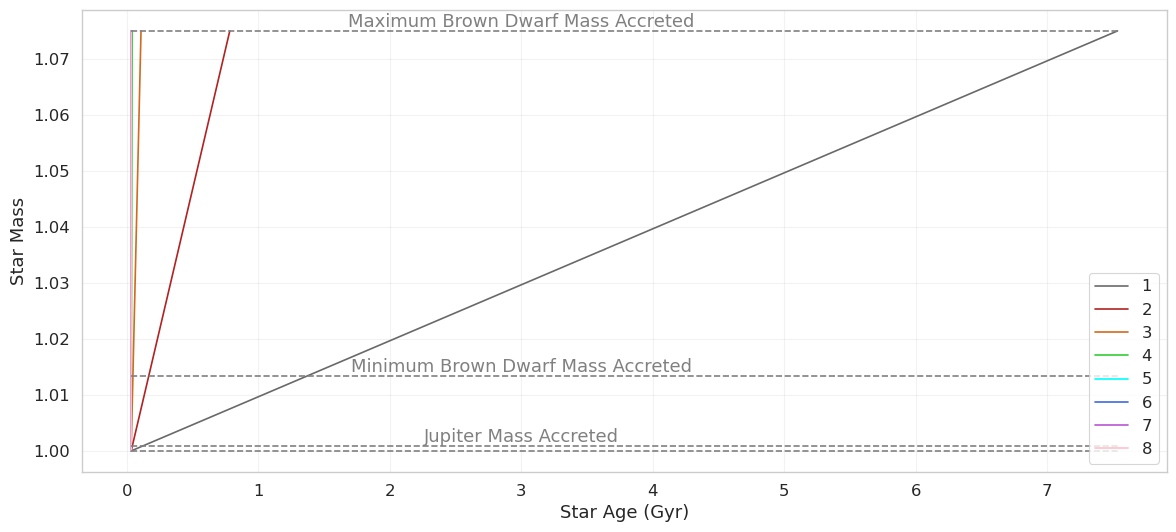

In [1021]:
# Assuming h1, h2, h3, h4, h5, h6, h7, h8 are available variables
stars = [h1, h2, h3, h4, h5, h6, h7, h8]

plt.figure(figsize=(14, 6))
i=0
for h in stars:
    label=str(h).split('/L')[0]
    label=label.split('000')[1]
    color = colors[i]
    plt.plot(h.star_age/1.0E9, h.star_mass, label=label,color=color)
    #plt.scatter(h.star_age/1.0E9, h.star_mass)
    i=i+1
emass=1+3.00273e-6
jmass=1+0.0009543
bdmass=1+0.0009543*14
maxbdmass=1+0.075
plt.hlines(emass,min(min(h8.star_age / 1.0E9), min(h1.star_age / 1.0E9)),max(max(h8.star_age / 1.0E9), max(h1.star_age / 1.0E9)),linestyle='dashed',color='grey')
#plt.annotate('Earth Mass Accreted', xy=(1, emass), xytext=(1, emass), color='grey', ha='center', va='bottom')

plt.hlines(jmass,min(min(h8.star_age / 1.0E9), min(h1.star_age / 1.0E9)),max(max(h8.star_age / 1.0E9), max(h1.star_age / 1.0E9)),linestyle='dashed',color='grey')
plt.annotate('Jupiter Mass Accreted', xy=(0, jmass), xytext=(3, jmass), color='grey', ha='center', va='bottom')

plt.hlines(bdmass,min(min(h8.star_age / 1.0E9), min(h1.star_age / 1.0E9)),max(max(h8.star_age / 1.0E9), max(h1.star_age / 1.0E9)),linestyle='dashed',color='grey')
plt.annotate('Minimum Brown Dwarf Mass Accreted', xy=(0, bdmass), xytext=(3, bdmass), color='grey', ha='center', va='bottom')

plt.hlines(maxbdmass,min(min(h8.star_age / 1.0E9), min(h1.star_age / 1.0E9)),max(max(h8.star_age / 1.0E9), max(h1.star_age / 1.0E9)),linestyle='dashed',color='grey')
plt.annotate('Maximum Brown Dwarf Mass Accreted', xy=(0, maxbdmass), xytext=(3, maxbdmass), color='grey', ha='center', va='bottom')

# Customize plot as needed
plt.xlabel('Star Age (Gyr)')
plt.ylabel('Star Mass')
plt.ticklabel_format(axis='x', style='plain')
plt.ticklabel_format(axis='y', style='plain')
plt.grid(alpha=0.25)
plt.legend()
plt.show()

In [448]:
h1.bulk_names

('model_number',
 'num_zones',
 'star_age',
 'log_dt',
 'star_mass',
 'log_xmstar',
 'log_abs_mdot',
 'mass_conv_core',
 'conv_mx1_top',
 'conv_mx1_bot',
 'conv_mx2_top',
 'conv_mx2_bot',
 'mx1_top',
 'mx1_bot',
 'mx2_top',
 'mx2_bot',
 'log_LH',
 'log_LHe',
 'log_LZ',
 'log_Lnuc',
 'pp',
 'cno',
 'tri_alpha',
 'epsnuc_M_1',
 'epsnuc_M_2',
 'epsnuc_M_3',
 'epsnuc_M_4',
 'epsnuc_M_5',
 'epsnuc_M_6',
 'epsnuc_M_7',
 'epsnuc_M_8',
 'he_core_mass',
 'co_core_mass',
 'one_core_mass',
 'fe_core_mass',
 'neutron_rich_core_mass',
 'log_Teff',
 'log_L',
 'log_R',
 'log_g',
 'v_div_csound_surf',
 'log_cntr_P',
 'log_cntr_Rho',
 'log_cntr_T',
 'center_mu',
 'center_ye',
 'center_abar',
 'center_h1',
 'center_he4',
 'center_c12',
 'center_o16',
 'surface_c12',
 'surface_o16',
 'total_mass_h1',
 'total_mass_he4',
 'num_retries',
 'num_iters')